In [1]:
from dataset_test import METRLADatasetLoader;

In [2]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset();

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

import random
import gc

In [3]:
import collections

In [4]:
adj_mat = [[0 for i in range(207)] for j in range(207)]
edge_attr = train_dataset[0].edge_attr
src = list(train_dataset[0].edge_index[0])
dest = list(train_dataset[0].edge_index[1])
for i in range(len(src)):
    adj_mat[int(src[i])][int(dest[i])] = float(edge_attr[i])
    if adj_mat[int(dest[i])][int(src[i])] == 0:
        adj_mat[int(dest[i])][int(src[i])] = float(edge_attr[i])

    

In [5]:
import pandas as pd
dataFrame = pd.DataFrame(adj_mat)


In [6]:
dic_speed = collections.defaultdict(list)
dic_density = collections.defaultdict(list)
limit = 12
test_train_dataset = train_dataset[1255 : 1268]
for dataset_snapshot in test_train_dataset:
    if(limit):
        for index, sensor in enumerate(dataset_snapshot.x):
            dic_speed[index].append(float(sensor[0][0]))
            dic_density[index].append(float(sensor[1][0]))
            
        limit -= 1
        
        
    

In [7]:
import numpy as np
import pandas as pd

# Example: Create a DataFrame with density values for each sensor
# Replace this example data with your actual sensor data

df_speed = pd.DataFrame(dic_speed)


# Calculate the correlation matrix
correlation_matrix_speed = df_speed.corr()
spearman_speed = df_speed.corr(method = "spearman")

In [8]:
import numpy as np


# Function to calculate correlation between two nodes using adjacency matrix
def calculate_correlation(node1, node2, correlation):
    return correlation[node1][node2] * ( adj_mat[node1][node2] )

# Function to grow subgraph using BFS
def grow_subgraph(adj_matrix, start_node, threshold):
    subgraph = set()
    queue = [start_node]
    while queue:
        current_node = queue.pop(0)
        if current_node not in subgraph:
            subgraph.add(current_node)
            neighbors = [x for x in range(len(adj_mat[0])) if adj_mat[current_node][x] > 0 and x != current_node]
            for neighbor in neighbors:
                if neighbor in unvisited_nodes:
                    correlation = calculate_correlation(current_node, neighbor, spearman_speed)
                    if np.isnan(correlation):
                        correlation = 0
                    correlation_list.append(correlation)
                    if correlation >= threshold:
                        queue.append(neighbor)
    return subgraph

# Set a correlation threshold for subgraph growth
correlation_threshold = 0.2  # Adjust as needed
correlation_list = []
# Create a list to keep track of nodes that are already part of a subgraph
unvisited_nodes = set(range(len(adj_mat[0])))

# Initialize an empty list to store the subgraphs
subgraphs = []

# Iterate through unvisited nodes to grow subgraphs
while unvisited_nodes:
    node = unvisited_nodes.pop()
    subgraph = grow_subgraph(adj_mat, node, correlation_threshold)
    subgraphs.append(subgraph)
    unvisited_nodes = unvisited_nodes.difference(subgraph)

# Print the resulting subgraphs
for i, subgraph in enumerate(subgraphs):
    print(f"Subgraph {i + 1}: {subgraph}")

Subgraph 1: {0, 67, 36, 37, 199, 140, 13, 142, 111, 143, 145, 114, 115, 116, 109, 54, 51, 58}
Subgraph 2: {1, 135, 177, 184, 123}
Subgraph 3: {2, 132, 7, 11, 152, 28, 167, 178, 53, 55, 183, 201, 78, 79, 85, 105, 106, 107, 110}
Subgraph 4: {192, 3, 5}
Subgraph 5: {33, 4, 6, 15}
Subgraph 6: {8, 185}
Subgraph 7: {9}
Subgraph 8: {10, 156}
Subgraph 9: {128, 12, 17, 20, 22, 154, 155, 157, 159, 160, 161, 162, 163, 32, 40, 176, 187, 188, 191, 193, 195, 68, 198, 70, 206, 80, 83, 90, 96, 97, 98, 102, 103, 122, 127}
Subgraph 10: {130, 131, 137, 141, 14, 146, 150, 151, 158, 164, 41, 43, 47, 52, 60, 190, 63, 69, 71, 72, 73, 75, 204, 77, 76, 81, 82, 84, 87, 88, 113}
Subgraph 11: {101, 166, 133, 134, 138, 16, 29}
Subgraph 12: {18, 35}
Subgraph 13: {39, 74, 175, 19, 119, 57, 94}
Subgraph 14: {200, 121, 50, 21}
Subgraph 15: {165, 174, 23}
Subgraph 16: {168, 169, 42, 171, 173, 24, 62}
Subgraph 17: {129, 49}
Subgraph 18: {136}
Subgraph 19: {139}
Subgraph 20: {144, 91, 93}
Subgraph 21: {147}
Subgraph 22: 

In [9]:
macro = collections.defaultdict(list)
for index,subgraph in enumerate(subgraphs):
    for i in range(len(dic_speed[0])):
        temp = []
        for sensor in subgraph:
            temp.append(dic_speed[sensor][i])
        macro[index].append(np.mean(temp))
            


In [10]:
macro_df = pd.DataFrame(macro)


# Calculate the correlation matrix
correlation_matrix_macros = macro_df.corr()

In [11]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h;

# GPU support
device = torch.device('cpu') # cuda
subset = 2000
# gc.collect() # garbage collector
# torch.cuda.empty_cache() # cuda

In [14]:
model_speed = TemporalGNN(node_features=2, periods=12).to(device)
model_density = TemporalGNN(node_features=2, periods=12).to(device)
optimizer_speed = torch.optim.Adam(model_speed.parameters(), lr=0.01)
optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.01)
model_speed.train()
model_density.train()

print("Running training...")
for epoch in range(20):
    loss_speed = 0
    loss_density = 0
    for step in range(subset):
        snapshot = train_dataset[step].to(device) # shift snapshot subset every epoch
#         snapshot = train_dataset[(epoch * subset) + step].to(device) # shift snapshot subset every epoch, do this later cause better training
        # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
        # Get model predictions
        y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
        y_hat_density = model_density(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
        loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)

    loss_speed = loss_speed / (step + 1)
    loss_density = loss_density / (step + 1)
    loss_speed.backward()
    loss_density.backward()
    optimizer_speed.step()
    optimizer_speed.zero_grad()
    optimizer_density.step()
    optimizer_density.zero_grad()
    print("Epoch speed {} train MSE: {:.4f}".format(epoch, loss_speed.item()))
    print("Epoch density {} train MSE: {:.4f}".format(epoch, loss_density.item()))

# gc.collect()
# torch.cuda.empty_cache()

Running training...
Epoch speed 0 train MSE: 0.7548
Epoch density 0 train MSE: 1.0032
Epoch speed 1 train MSE: 0.7380
Epoch density 1 train MSE: 0.9672
Epoch speed 2 train MSE: 0.7212
Epoch density 2 train MSE: 0.9295
Epoch speed 3 train MSE: 0.7021
Epoch density 3 train MSE: 0.8826
Epoch speed 4 train MSE: 0.6807
Epoch density 4 train MSE: 0.8231
Epoch speed 5 train MSE: 0.6591
Epoch density 5 train MSE: 0.7514
Epoch speed 6 train MSE: 0.6406
Epoch density 6 train MSE: 0.6705
Epoch speed 7 train MSE: 0.6276
Epoch density 7 train MSE: 0.5853
Epoch speed 8 train MSE: 0.6182
Epoch density 8 train MSE: 0.5028
Epoch speed 9 train MSE: 0.6086
Epoch density 9 train MSE: 0.4311
Epoch speed 10 train MSE: 0.5969
Epoch density 10 train MSE: 0.3781
Epoch speed 11 train MSE: 0.5838
Epoch density 11 train MSE: 0.3495
Epoch speed 12 train MSE: 0.5715
Epoch density 12 train MSE: 0.3440
Epoch speed 13 train MSE: 0.5618
Epoch density 13 train MSE: 0.3519
Epoch speed 14 train MSE: 0.5554
Epoch density 1

In [16]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./traffic_prediction_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_speed, file)

In [12]:
import pickle

model_pkl_file = "./traffic_prediction_model.pkl"

model_speed = pickle.load(open(model_pkl_file, 'rb'))

In [17]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./traffic_prediction_density_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_density, file)

In [13]:
import pickle

model_pkl_file = "./traffic_prediction_density_model.pkl"

model_density = pickle.load(open(model_pkl_file, 'rb'))

0
1
2
3
4
5
6
7
8
9
10
11
12


In [14]:
model_speed.eval()
model_density.eval()
loss_speed = 0
loss_density = 0
horizon = 288

# Store for analysis
predictions_speed = []
labels_speed = []
predictions_density = []
labels_density = []
anomalies_speed = [test_dataset[i].y.permute(1, 0, 2)[0] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph
anomalies_density = [test_dataset[i].y.permute(1, 0, 2)[1] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

for step in range(horizon):
    snapshot = test_dataset[step].to(device)
    # Get predictions
    y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
    y_hat_density = model_density(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
    loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)
    if step > 1:
        # acceleration or deviation
        acc_speed = torch.mean(abs((y_hat_speed - predictions_speed[-1]) / predictions_speed[-1]))
        if acc_speed > 1: # random value for now
            anomalies_speed[step] = y_hat_speed # mark point on predicted graph if it exceeds some threshold of acceleration
        acc_density = torch.mean(abs((y_hat_density - predictions_density[-1]) / predictions_density[-1]))
        if acc_density > 1: # random value for now
            anomalies_density[step] = y_hat_density # mark point on predicted graph if it exceeds some threshold of acceleration
    labels_speed.append(snapshot.y.permute(1, 0, 2)[0])
    labels_density.append(snapshot.y.permute(1, 0, 2)[1])
    predictions_speed.append(y_hat_speed)
    predictions_density.append(y_hat_density)

loss_speed = loss_speed / (step+1)
loss_speed = loss_speed.item()
loss_density = loss_density / (step+1)
loss_density = loss_density.item()

print("Test speed MSE: {:.4f}".format(loss_speed))
print("Test density MSE: {:.4f}".format(loss_density))

# gc.collect()
# torch.cuda.empty_cache()

Test speed MSE: 0.6836
Test density MSE: 0.3227


In [15]:
y_hat_speed.shape

torch.Size([207, 12])

In [16]:
import numpy as np

sensor = 30
timestep = 11
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_speed])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_speed])
anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_speed])
preds1 = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_density])
labs1  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_density])
anoms1 = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_density])

<Axes: >

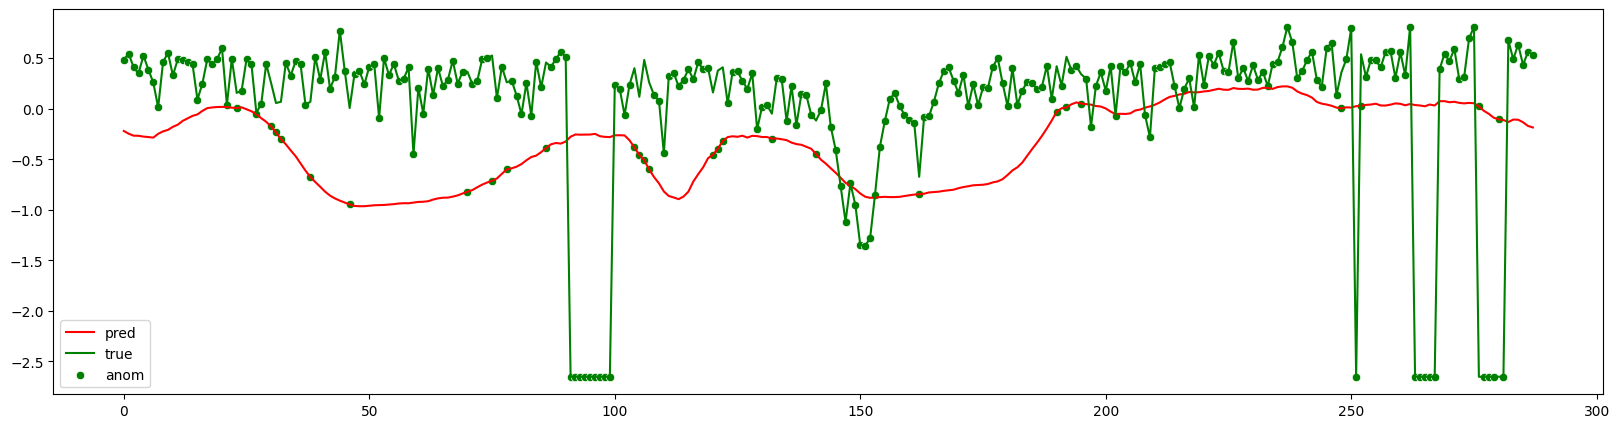

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true", color='green')
sns.scatterplot(data=anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

<Axes: >

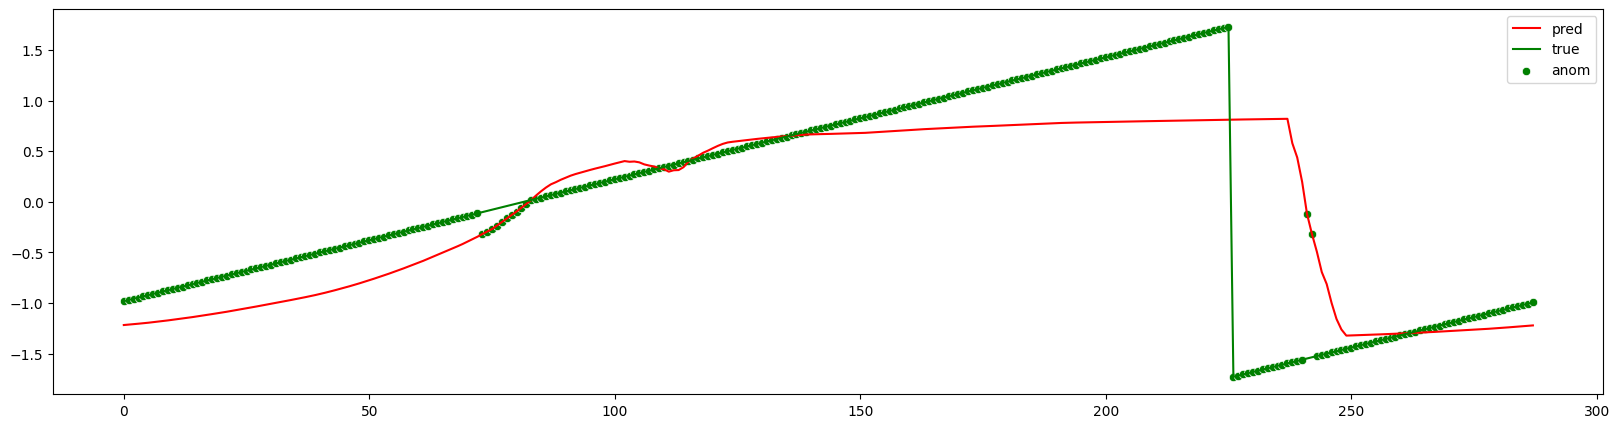

In [39]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds1, label="pred", color='red')
sns.lineplot(data=labs1, label="true", color='green')

sns.scatterplot(data=anoms1, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

In [18]:
def subgraph_anomaly_detection(subgraph, curr_hour, pred_hour):
    #dimensions: subgraph-set, curr_hour-snapshot of graph during current hour (207x2x12), pred_hour-model predicted snapshot of graph for the next hour (207x12)
    curr_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(curr_hour[sensor][0][timestep])
        curr_means.append(np.mean(temp))
#     print("curr_means = ", curr_means)
    base = np.mean(curr_means)
#     print("base = ", base)
    dev = np.std(curr_means)
#     print("dev = ", dev)
    pred_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(pred_hour[sensor][timestep])
        pred_means.append(np.mean(temp))
#     print("pred_means = ", pred_means)
    anoms = []
    for i in pred_means:
        anoms.append(max(0.0, abs(i - base) - dev))
#     print("anoms = ", anoms)
#     print("norm = ", np.linalg.norm(anoms))
    return anoms
#     norm_anoms = []
#     if np.linalg.norm(anoms) == 0:
#         return anoms
#     else:
#         print("normalized anoms = ", norm_anoms)
#         for i in anoms:
#             norm_anoms.append(abs(i) / np.linalg.norm(anoms))
#         return norm_anoms

In [60]:
test_snapshot = train_dataset[1784]
predicted = model_speed(test_snapshot.x, test_snapshot.edge_index).detach().cpu().numpy()
print(subgraph_anomaly_detection(subgraphs[0], test_snapshot.x, predicted))

[0.0, 0.0, 0.016919956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [61]:
def find_all_subgraph_anomalies(subgraphs, curr_hour, pred_hour):
    anomaly_list = []
    norm_anomaly_list = []
    mean_anomaly_list = {}
    max_val = 0.0
    for index, subgraph in enumerate(subgraphs):
        # ans = subgraph_anomaly_detection(i, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])
        ans = subgraph_anomaly_detection(subgraph, curr_hour, pred_hour)
        anomaly_list.append(ans)
        max_val = max(max_val,max(ans))
    print("Max : ",max_val)
    for index, anom in enumerate(anomaly_list):
        temp = 0.0
        count = 0
        print("INDEX ",index)
        print("Prev : ",anom)
        norm_anoms = [x/max_val for x in anom]
        print("Normalized :",norm_anoms)
        norm_anomaly_list.append(norm_anoms)
        for i in norm_anoms:
            if i > 0:
                temp += i
                count += 1
        if(count == 0):
            mean_anomaly_list[index] = temp
        else:
            mean_anomaly_list[index] = temp / count
    return (norm_anomaly_list, mean_anomaly_list)

In [62]:
anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, train_dataset[1784].x, predicted)

Max :  1.9445646
INDEX  0
Prev :  [0.0, 0.0, 0.016919956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized : [0.0, 0.0, 0.008701154, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
INDEX  1
Prev :  [0.6398157, 0.6765435, 0.72919786, 0.6377301, 0.65252066, 0.68741477, 0.611338, 0.67146367, 0.5416085, 0.5738394, 0.60151005, 0.6023724]
Normalized : [0.32902774, 0.34791514, 0.37499288, 0.32795522, 0.3355613, 0.35350576, 0.314383, 0.34530285, 0.2785243, 0.2950992, 0.3093289, 0.30977237]
INDEX  2
Prev :  [0.008977465, 0.0, 0.043551914, 0.024804197, 0.018128477, 0.0, 0.0, 0.07778423, 0.09528034, 0.11780395, 0.0098698065, 0.08736058]
Normalized : [0.004616697, 0.0, 0.022396743, 0.012755657, 0.0093226405, 0.0, 0.0, 0.04000085, 0.048998293, 0.060581148, 0.005075587, 0.044925526]
INDEX  3
Prev :  [0.0, 0.0, 0.027467497, 0.018496878, 0.0, 0.0, 0.0, 0.05098609, 0.052721895, 0.06595514, 0.0, 0.042922683]
Normalized : [0.0, 0.0, 0.014125268, 0.009512093, 0.0, 0.0, 0.0, 0.026219796, 0.027112443, 0

In [63]:
anomaly_list

[[0.0, 0.0, 0.008701154, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.32902774,
  0.34791514,
  0.37499288,
  0.32795522,
  0.3355613,
  0.35350576,
  0.314383,
  0.34530285,
  0.2785243,
  0.2950992,
  0.3093289,
  0.30977237],
 [0.004616697,
  0.0,
  0.022396743,
  0.012755657,
  0.0093226405,
  0.0,
  0.0,
  0.04000085,
  0.048998293,
  0.060581148,
  0.005075587,
  0.044925526],
 [0.0,
  0.0,
  0.014125268,
  0.009512093,
  0.0,
  0.0,
  0.0,
  0.026219796,
  0.027112443,
  0.03391769,
  0.0,
  0.022073159],
 [0.05508259,
  0.048380733,
  0.07014478,
  0.06473818,
  0.05420095,
  0.03541601,
  0.040952712,
  0.08427306,
  0.08909185,
  0.09738593,
  0.051820412,
  0.08381968],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.08246947,
  0.09087248,
  0.06704896,
  0.07268625,
  0.081187785,
  0.10279485,
  0.09780424,
  0.05021773,
  0.043161917,
  0.03424222,
  0.08425304,
  0.04991674],
 [0.0146

In [64]:
anomaly_list[16]

[0.864939,
 0.8540015,
 0.8052846,
 0.88214195,
 0.8436856,
 0.8036477,
 0.8805008,
 0.8703893,
 1.0,
 0.96321625,
 0.9125879,
 0.93302447]

In [23]:
subgraph_anomaly_detection(subgraphs[16], train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012574017, 0.0]

In [65]:
mean_anomaly_dict

{0: 0.00870115403085947,
 1: 0.3267807240287463,
 2: 0.02763034874159429,
 3: 0.02216007513925433,
 4: 0.06460890732705593,
 5: 0.0,
 6: 0.0,
 7: 0.07138797361403704,
 8: 0.027897250484432912,
 9: 0.02211649902164936,
 10: 0.09510860592126846,
 11: 0.0,
 12: 0.011049600900150836,
 13: 0.007269106029222409,
 14: 0.23925619075695673,
 15: 0.17728544399142265,
 16: 0.8844515879948934,
 17: 0.1516656968742609,
 18: 0.7545801599820455,
 19: 0.025425799074582756,
 20: 0.7682686795790991,
 21: 0.02440585211540262,
 22: 0.0467578312382102,
 23: 0.7846556454896927,
 24: 0.037773900432512164,
 25: 0.0,
 26: 0.11639488488435745,
 27: 0.6338933209578196,
 28: 0.045256623066961765,
 29: 0.10431623520950477,
 30: 0.3113252843419711,
 31: 0.6102569450934728,
 32: 0.11490289183954398,
 33: 0.8157673428455988,
 34: 0.051916791452094914,
 35: 0.1791301853954792,
 36: 0.0057421165984123945,
 37: 0.0,
 38: 0.01761351039426194,
 39: 0.7786259104808172,
 40: 0.0,
 41: 0.04011130431253049,
 42: 0.05454776560

In [66]:
def top_k_anomalous_subgraphs(k, mean_anomaly_dict):
    sorted_mean_anomaly_dict = sorted(mean_anomaly_dict.items(), key = lambda x : x[1], reverse = True)
    top_k_anomaly = [x for x, y in sorted_mean_anomaly_dict]
    return top_k_anomaly[0 : k]
    

In [67]:
anomalous_subgraphs = top_k_anomalous_subgraphs(15, mean_anomaly_dict)

In [68]:
anomalous_subgraphs

[16, 33, 23, 39, 20, 18, 27, 31, 46, 43, 47, 48, 52, 1, 30]

In [69]:
def micro_feature_analysis(anomalous_subgraphs, curr_hour, pred_hour):
    anomalous_analysis = {}
    for anomalous_subgraph in anomalous_subgraphs:
        anomalous_analysis[anomalous_subgraph] = {}
        for node in subgraphs[anomalous_subgraph]:
            anomalous_analysis[anomalous_subgraph][node] = []
            
            curr_hour_node_values = [float(x) for x in curr_hour[node][0]]
            curr_hour_node_mean = np.mean(curr_hour_node_values)
            curr_hour_node_dev = np.std(curr_hour_node_values)
            print("curr node is", node)
            print("curr node values" , curr_hour_node_values)
            print("Curr node mean ", curr_hour_node_mean)
            print("Curr node dev", curr_hour_node_dev)
            
            pred_hour_node_values = [float(x) for x in pred_hour[node]]
            for step in range(len(pred_hour[0])): #the range is basically how many timesteps, which is 12 here
                #anom = max(0.0, abs((pred_hour[node][step] - curr_hour_node_mean) - 2 * curr_hour_node_dev))
                anom = max(0.0, abs(pred_hour[node][step] - curr_hour_node_mean) - 2 * curr_hour_node_dev)
                print("predicted at time step", step, " is ", float(pred_hour[node][step]))
                if(anom):
                    anomalous_analysis[anomalous_subgraph][node].append(step)
                    
    return anomalous_analysis
                    
        

In [44]:
subgraphs[17]

{136}

In [70]:
micro_feature_analysis(anomalous_subgraphs, train_dataset[1784].x, predicted)

curr node is 129
curr node values [-2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143]
Curr node mean  -2.6521542072296143
Curr node dev 0.0
predicted at time step 0  is  -1.1675169467926025
predicted at time step 1  is  -1.158891201019287
predicted at time step 2  is  -1.277632236480713
predicted at time step 3  is  -1.1266037225723267
predicted at time step 4  is  -1.226951003074646
predicted at time step 5  is  -1.3133224248886108
predicted at time step 6  is  -1.144066572189331
predicted at time step 7  is  -1.1472846269607544
predicted at time step 8  is  -0.8413670063018799
predicted at time step 9  is  -0.9357262849807739
predicted at time step 10  is  -1.0403839349746704
predicted at time step 11  is  -0.9957329630851746
curr node is 49
curr node values [-2.6521542072296143, -2.652

{16: {129: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  49: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 33: {194: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 23: {120: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  25: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 39: {170: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 20: {147: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 18: {139: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 27: {65: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  30: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 31: {64: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 46: {117: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 43: {112: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 47: {61: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 48: {118: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 52: {125: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  95: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 1: {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  135: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  177: [],
  184: [],
  123: [0, 1, 2, 3, 4, 5, 

In [73]:
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [74]:
def prediction_based_anomaly(next_real_values, next_predictions, previous_real_values, previous_predictions,node):
    
    print(next_real_values)
    # Calculate the residuals for the previous and next 12 timesteps
    previous_residuals = np.array(previous_predictions[node]) - np.array(previous_real_values[node])
    next_residuals = np.array(next_predictions[node]) - np.array(next_real_values[node])

    # Calculate z-scores for the residuals of the previous 12 timesteps
    z_scores_previous = zscore(previous_residuals)
    print(z_scores_previous,previous_residuals,next_residuals)
    # Define a threshold for anomaly detection based on the z-scores of the previous residuals
    anomaly_threshold = np.mean(np.abs(z_scores_previous))
    
    print("z scores previous is ", z_scores_previous)
    
    print("Threshold is ", anomaly_threshold)

    # Calculate z-scores for the residuals of the next 12 timesteps
    z_scores_next = zscore(next_residuals)
    print("ZSCORES NEXT",z_scores_next)

    # Identify anomalies in the residuals of the next 12 timesteps
    anomalies = np.where(np.abs(z_scores_next) > anomaly_threshold)[0]

    print("Previous Residuals:", previous_residuals)
    print("Next Residuals:", next_residuals)
    print("Anomalies (indices):", anomalies)
    

In [91]:
#anomalous_subgraphs, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0]
#anomalous_subgraphs, curr_hour, pred_hour
#next_real_values, next_predictions, previous_real_values, previous_predictions

In [75]:
next_test_snapshot = train_dataset[1784]
cur_test_snapshot = train_dataset[1784 - 12]
prev_test_snapshot = train_dataset[1784 - 12 - 12]
cur_prediction = model_speed(prev_test_snapshot.x, prev_test_snapshot.edge_index).detach().cpu().numpy()
next_prediction = model_speed(cur_test_snapshot.x, cur_test_snapshot.edge_index).detach().cpu().numpy()
prediction_based_anomaly(next_test_snapshot.x.permute(1, 0, 2)[0], next_prediction ,cur_test_snapshot.x.permute(1, 0, 2)[0], cur_prediction, 48)

tensor([[0.4431, 0.7125, 0.2920,  ..., 0.4816, 0.6521, 0.5146],
        [0.5311, 0.4899, 0.0507,  ..., 0.1298, 0.3057, 0.4816],
        [0.6301, 0.7497, 0.5455,  ..., 0.7235, 0.6960, 0.7070],
        ...,
        [0.4541, 0.4528, 0.3909,  ..., 0.2947, 0.2342, 0.1957],
        [0.5806, 0.4528, 0.1311,  ..., 0.5696, 0.5916, 0.6026],
        [0.5256, 0.4590, 0.4342,  ..., 0.5091, 0.5476, 0.6026]])
[-0.00469591 -2.3340573  -0.4796521  -0.38483775 -0.17020826  0.24160875
 -0.3405129   0.7772282   0.72472185  0.10243222  2.1762094  -0.30823112] [-0.6335777  -0.927467   -0.69350165 -0.6815392  -0.65445995 -0.6025021
 -0.67594683 -0.53492445 -0.541549   -0.62006164 -0.35841873 -0.6718739 ] [-0.98593676 -1.2623581  -1.2378556  -1.0089643  -0.9672619  -1.1433214
 -1.0140241  -0.9479121  -0.76206917 -0.88983464 -0.9031402  -0.98879313]
z scores previous is  [-0.00469591 -2.3340573  -0.4796521  -0.38483775 -0.17020826  0.24160875
 -0.3405129   0.7772282   0.72472185  0.10243222  2.1762094  -0.3082

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

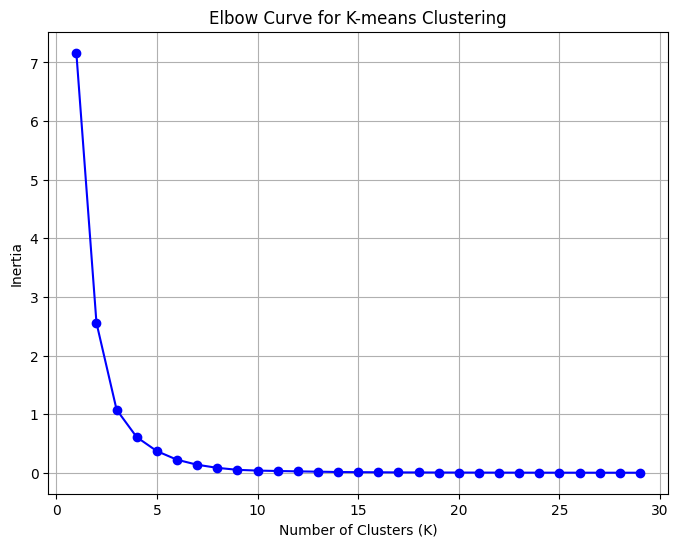

Elbow point is  2
cluster assignments are , [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


IndexError: index 10 is out of bounds for axis 0 with size 10

In [80]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

subgraph_means = {}

for index, subgraph in enumerate(subgraphs):
    node_speeds = []
    for node in subgraph:
        node_speeds.append(torch.mean(train_dataset[9231].x[node][0]))
        
    subgraph_means[index] = np.mean(node_speeds)


# subgraph_means_pd = pd.DataFrame(subgraph_means)    
k_values = range(1, 30)
# k = 2
inertias = []
feature_list = list(subgraph_means.values())

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    #feature_list = list(subgraph_means.values())
    kmeans.fit(np.array(feature_list).reshape(-1, 1))  # X is your data
    inertias.append(kmeans.inertia_)
    
diff1 = np.diff(inertias)
diff2 = np.diff(diff1)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

elbow_point = np.where(diff2 == max(diff2))[0][0] + 2

print("Elbow point is ", elbow_point)
kmeans = KMeans(n_clusters=elbow_point, random_state=0)
kmeans.fit(np.array(feature_list).reshape(-1, 1))
cluster_labels = kmeans.labels_
print("cluster assignments are ,",  cluster_labels)

import matplotlib.pyplot as plt
#Initialize lists to store data points for each cluster
cluster_data = [[] for _ in range(elbow_point)]

# Organize data points by cluster
for i, label in enumerate(cluster_labels):
    if label == cluster:
        cluster_data[label].append(feature_values[i])
# Plot the data points colored by their cluster assignment
for cluster in range(elbow_point):
    plt.scatter(cluster_data[cluster], [cluster] * np.sum(cluster_labels == cluster), label=f'Cluster {cluster}')

plt.xlabel('Feature Value')
plt.ylabel('Cluster')
plt.legend()
plt.title('K-means Clustering with a Single Feature')
plt.show()


In [78]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [77]:
feature_list

[0.18046257,
 0.57730365,
 0.18696906,
 0.51239395,
 0.6362957,
 0.4192016,
 0.622324,
 0.09245081,
 0.5437468,
 0.41810068,
 0.27622607,
 -0.16824375,
 0.50550836,
 0.38136286,
 0.2946992,
 0.31392813,
 0.35631567,
 0.6870467,
 0.5023609,
 0.32155582,
 0.3836086,
 0.5196972,
 0.67045486,
 0.33434057,
 0.5175087,
 0.42632344,
 0.46768832,
 0.5327669,
 0.6663806,
 0.6070298,
 0.40751448,
 0.55433697,
 -1.4976025,
 0.020864015,
 -0.8080456,
 -0.18466778,
 0.6491425,
 0.013607178,
 0.4013949,
 0.2538525,
 0.3410411,
 0.7649985,
 0.4421871,
 0.31229997,
 0.69795233,
 0.11106341,
 0.6097493,
 0.23314548,
 0.56865436,
 0.17228441,
 0.42507982,
 0.3283927,
 0.21960941]

In [172]:
print(value_diff)

[  2   2   7   2   3 -14  -3   2   4]
